<a href="https://colab.research.google.com/github/kirath2205/Neural-Network-Assignment-1/blob/main/start_1a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this cell we import the required libraries for our project



---



In [ ]:


import tensorflow
import pandas as pd
import time
import numpy as np
import statistics

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt



# Read Data



---



In [ ]:


df = pd.read_csv('./features_30_sec.csv')



In [ ]:


df['label'].value_counts()



reggae       100
blues        100
jazz         100
rock         100
pop          100
classical    100
disco        100
hiphop       100
metal        100
country      100
Name: label, dtype: int64

#Question 1


In this cell, we pre-process the data and split the data into train and test 



---



In [ ]:


columns_to_drop = ['label','filename', 'length']

def prepare_dataset_question1(df, columns_to_drop, test_size, random_state):

    # Encode the labels from 0 to n_classes-1  
    label_encoder = preprocessing.LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
  
    # devide data to train and test
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # scale the training inputs
    x_train = df_train.drop(columns_to_drop,axis=1)
    y_train = df_train['label'].to_numpy()
    
    standard_scaler = preprocessing.StandardScaler()
    x_train_scaled = standard_scaler.fit_transform(x_train)

    #scale and prepare testing data
    x_test = df_test.drop(columns_to_drop,axis=1)
    x_test_scaled = standard_scaler.transform(x_test)
    y_test = df_test['label'].to_numpy() 
  
    return x_train_scaled, y_train, x_test_scaled, y_test



In [ ]:


# Splitting the data into train and test with a 70:30 split
X_train, y_train, X_test, y_test = prepare_dataset_question1(df, columns_to_drop, test_size=0.3, random_state=0)





Creating functions to build and train models

1. build_model - This function accepts parameters including total_classes , input_shape , hidden_layer_neurons , hidden_layers (denotes total number of hidden layers in the model architecture) , need_drop_out (denotes if the dropout layer needs to be added in the architecture , dropout_probability , optimizer . This function declares the model architecture as well as compiles it and returns the model

2. train_model - This function accepts parameters including the keras model, epochs , X_train , y_train , X_test , y_test , batch_size , callbacks. This function essentially fits the model on the training data and tests it on the test data and returns the history denoting the results of the model





---



In [ ]:


def build_model(total_classes,input_shape,hidden_layer_neurons=16,hidden_layers=1,need_drop_out=True,dropout_probability=0.3,optimizer='adam'):

  model=tf.keras.models.Sequential()
  model.add(keras.layers.Input(shape=input_shape))

  for i in range(hidden_layers):
    model.add(keras.layers.Dense(hidden_layer_neurons, activation="relu"))

    if(need_drop_out):
      model.add(keras.layers.Dropout(dropout_probability))

  model.add(keras.layers.Dense(total_classes, activation='softmax'))
  model.compile(optimizer=optimizer,metrics=['accuracy'],loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

  return model

def train_model(model,epochs,X_train,y_train,X_test,y_test,batch_size=1,callbacks=[]):

  history=model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test,y_test),callbacks=callbacks)
  return history



#Question 1 Part a)


In [ ]:


history={}
model=build_model(10,X_train[0].shape)
history['question-1']=train_model(model,50,X_train,y_train,X_test,y_test)



#Question 1 Part b)

In [ ]:


plt.plot(history['question-1'].history['accuracy'])
plt.plot(history['question-1'].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['question-1'].history['loss'])
plt.plot(history['question-1'].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



#Question 2

Adding a callback to find spoch times during training



---



In [ ]:


class TimeHistory(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()
        
    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)



This cell is used to create models for different batch-sizes over 3 fold cross validation



---



In [ ]:


n_splits=3 # total number of folds in the cross-validation

kf = KFold(n_splits=n_splits) # creating KFold object 

batch_sizes=[1,4,8,16,32,64] # batch_sizes list denotes the search space of the batch sizes given in the assignment handout

total_classes=10 # denotes total number of classes

input_shape=X_train[0].shape # denotes input shape

history={} # denotes a history dictionary to save the results of the trained model

k_fold=1 # denotes the current k_fold during the experiment 

epochs=50 # denotes total epochs

epoch_times={} # denotes a dictionary to save the epoch times during cross-validation to find median epoch times later

for element in batch_sizes:

  for fold in range(1,4):
    epoch_times[(element,fold)]=[]

for train,test in kf.split(X_train):

  X_train_cross_validation , X_test_cross_validation = X_train[train] , X_train[test]
  y_train_cross_validation , y_test_cross_validation = y_train[train] , y_train[test]

  for batch_size in batch_sizes:

    print()
    print('Model for batch size ',batch_size, ' and fold ',k_fold)

    tf.keras.backend.clear_session()
    model=build_model(total_classes,input_shape)
    time_callback = TimeHistory()
    history[(batch_size,k_fold)] = train_model(model,epochs,X_train_cross_validation,y_train_cross_validation,X_test_cross_validation,y_test_cross_validation,batch_size,[time_callback])
    
    for element in time_callback.times: # this for-loop code is used to save epoch_times for the respective batch_size and k_fold pair
      epoch_times[(batch_size,k_fold)].append(element)

  k_fold+=1



This cell essentially calculates the mean cross validation accuracies over 3 folds for the respective batch sizes



---



In [ ]:


mean_cross_validation_accuracies=[]

for batch_size in batch_sizes:
  temp=[]

  for k_fold in range(1,4):
    temp.append(history[batch_size,k_fold].history['val_accuracy'])

  mean_accuracy=[0]*epochs

  for list1 in temp:

    for epoch in range(len(list1)):
      mean_accuracy[epoch]+=list1[epoch]
  
  for i in range(epochs):
    mean_accuracy[i]=mean_accuracy[i]/3
    
  mean_cross_validation_accuracies.append(mean_accuracy.copy())


#Question 2 a)

In [ ]:


epoch_list=[(i+1) for i in range(epochs)]

for index in range(len(batch_sizes)):
  batch_size=batch_sizes[index]
  mean_accuracy_list=mean_cross_validation_accuracies[index]
  plt.xlabel('epochs')
  plt.ylabel('cross-validation accuracy')
  plt.plot(epoch_list, mean_accuracy_list, label = 'batch size of '+str(batch_sizes[index]))
  plt.legend()
  plt.show()

  

This cell finds out the list of mean epoch times for different batch sizes over 3 fold cross validation and then uses this mean epoch times list to find out the median epoch time for the respective batch size



---



In [ ]:


mean_epoch_times={}
median_epoch_times = {}

for batch_size in batch_sizes:
  mean_epoch_times[batch_size] = [0] * 50

for batch_size in batch_sizes:

  for key in epoch_times.keys():

    if(key[0]==batch_size):

      for epoch in range(50):
        mean_epoch_times[batch_size][epoch] += epoch_times[key][epoch]

for batch_size in batch_sizes:

  for epoch in range(50):
    mean_epoch_times[batch_size][epoch] = mean_epoch_times[batch_size][epoch]/2

for batch_size in mean_epoch_times.keys():
  median_epoch_times[batch_size] = float("{:.2f}".format(statistics.median(mean_epoch_times[batch_size])))

median_epoch_time_table=pd.DataFrame(median_epoch_times.items(),columns=['Batch_size','Median epoch time'])



#Question 2 b)

In this cell we display the table containing the median epoch times for the respective batch sizes



---



In [ ]:


median_epoch_time_table.index = median_epoch_time_table.index + 1
median_epoch_time_table # pandas dataframe that holds the median epoch time for the various batch sizes



,Batch_size,Median time
1,1,1.26
2,4,0.35
3,8,0.22
4,16,0.12
5,32,0.09
6,64,0.06


#Question 2 parts c) d) and e)

In this cell, we create a parameter optimal_batch_size, that denotes the selected optimal batch size for the model. Then we build and train the model, with the optimal batch size, on the original train and test data, additionally we plot the train and test accuracies for the model with the optimal batch size



---



In [ ]:


epoch_list=[(i+1) for i in range(epochs)] 

optimal_batch_size = 32 # denotes the selected optimal batch size for the model

print('Model for optimal batch size ',optimal_batch_size)

tf.keras.backend.clear_session()
model=build_model(total_classes,input_shape)
time_callback = TimeHistory()
history['optimal_batch_size_model'] = train_model(model,epochs,X_train,y_train,X_test,y_test,optimal_batch_size,[time_callback])

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('test and train accuracy for batch size - '+str(optimal_batch_size))
plt.plot(epoch_list,history['optimal_batch_size_model'].history['accuracy'],label='train accuracy')
plt.plot(epoch_list,history['optimal_batch_size_model'].history['val_accuracy'],label='test accuracy')
plt.legend(['train','test'] , loc='upper right')



#Question 3


In this cell we create models for different hidden-layer neurons over 3 fold cross validation

In [ ]:


hidden_layer_neuron_list=[8, 16, 32, 64] # denotes the search space for the total number of neurons in the hidden layer as given in the assignment handout

k_fold = 1

for train,test in kf.split(X_train):

  X_train_cross_validation , X_test_cross_validation = X_train[train] , X_train[test]
  y_train_cross_validation , y_test_cross_validation = y_train[train] , y_train[test]

  for hidden_layer_neurons in hidden_layer_neuron_list:

    print()
    print('Model for ',hidden_layer_neurons, ' neurons and fold ',k_fold)
    tf.keras.backend.clear_session()
    model=build_model(total_classes,input_shape,hidden_layer_neurons)
    history[(hidden_layer_neurons,k_fold)] = train_model(model,epochs,X_train_cross_validation,y_train_cross_validation,X_test_cross_validation,y_test_cross_validation,optimal_batch_size,[time_callback])

  k_fold+=1



This cell is used to find the mean cross validation accuracies for different hidden layer neurons over 3 fold cross-validation



---



In [ ]:


mean_cross_validation_accuracies=[]

for hidden_layer_neurons in hidden_layer_neuron_list:

  temp=[]
  for key in history.keys():

    if(key[0]==hidden_layer_neurons):
      temp.append(history[key].history['val_accuracy'])

  mean_accuracy=[0]*epochs

  for element in temp:

    for epoch in range(epochs):
      mean_accuracy[epoch]+=element[epoch]

  for epoch in range(epochs):
    mean_accuracy[epoch]=mean_accuracy[epoch]/n_splits
    
  mean_cross_validation_accuracies.append(mean_accuracy)



#Question 3 a)

In [ ]:


plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('mean cross-validation accuracies for different neurons')

for index in range(len(hidden_layer_neuron_list)):
  hidden_layer_neurons=hidden_layer_neuron_list[index]
  mean_accuracy_list=mean_cross_validation_accuracies[index]
  plt.plot(epoch_list, mean_accuracy_list, label = 'Total hidden neurons of '+str(hidden_layer_neuron_list[index]))
  plt.legend()
  plt.show()



#Question 3 b), c) and d)

In this cell, we create a variable optimal_neurons that denotes the selected optimal number of hidden layer neurons. Then we train a model with the optimal hidden layer neurons on the original train data and test it on the test data and plot the corresponding train and test accuracies.



---



In [ ]:


optimal_neurons = 64
print('Model for optimal neurons ',optimal_neurons)
tf.keras.backend.clear_session()
model=build_model(total_classes,input_shape,optimal_neurons)
time_callback = TimeHistory()
history['optimal_neuron_model'] = train_model(model,epochs,X_train,y_train,X_test,y_test,optimal_batch_size,[time_callback])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('test and train accuracy for - '+str(optimal_neurons)+' neurons')
plt.plot(epoch_list,history['optimal_neuron_model'].history['accuracy'],label='train accuracy')
plt.plot(epoch_list,history['optimal_neuron_model'].history['val_accuracy'],label='test accuracy')
plt.legend(['train','test'] , loc='upper right')



#Question-4 a) and b)

In this cell, we train the model with 2 hidden layers and a batch size of 1 on the orignal train data and test it on the original test data




---



In [ ]:


total_classes=10
image_shape=X_train[0].shape
hidden_layers=2
history={}
batch_size=1
model=build_model(total_classes,image_shape,optimal_neurons,hidden_layers)
history['question-4']=train_model(model,50,X_train,y_train,X_test,y_test,batch_size)



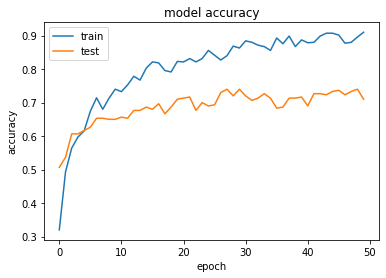

In [ ]:


plt.plot(history['question-4'].history['accuracy'])
plt.plot(history['question-4'].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



#Question-5 part a), b) and c)


In this cell, we build a model by excluding the hidden layers 



---



In [ ]:


history={}
model=build_model(10,X_train[0].shape)
hidden_layer_neurons=16
hidden_layers=1
epochs=50
total_classes=10
need_drop_out=False # denotes the exclusion of dropout layers
input_shape=X_train[0].shape
batch_size=1
model=build_model(total_classes,input_shape,hidden_layer_neurons,hidden_layers,need_drop_out)
history={}
history['question-5']=train_model(model,50,X_train,y_train,X_test,y_test,batch_size)



In [ ]:


plt.plot(history['question-5'].history['accuracy'])
plt.plot(history['question-5'].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['question-5'].history['loss'])
plt.plot(history['question-5'].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

